# Dataset 3 processing and descriptive analysis

This notebooks loads and processes the Dataset 3 and analyzes its mapping with PathMe, stratificating it by omic and by database.

Finally, it exports to the format ready to be used by DiffuPy/DiffuPath

In [1]:
import os 
import pybel
from pybel_tools.summary import plot_summary, count_top_centrality
import matplotlib.pyplot as plt

import json
import networkx as nx

from diffupath.constants import DEFAULT_DIFFUPATH_DIR, ROOT_RESULTS_DIR
from diffupath.pathme_processing import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap

from diffupy.process_network import process_graph_from_file
from diffupy.process_input import process_input_data
from diffupy.utils import lists_combinations, parse_xls_to_df, to_json
from diffupy.constants import *

## 1. Load and process dataset

### 1.1. Dataset excel file parsing

In [2]:
VALIDATION_PATH = os.path.join(ROOT_RESULTS_DIR, 'data', 'validation_datasets')
VALSET_3_PATH = os.path.join(VALIDATION_PATH, 'set3.xlsx')

##### Parsing parameters

In [3]:
relevant_sheets = ['metabolites', 
                 'genes', 
                 'mirnas']

relevant_cols = ['miRNA', 
                 'Gene name', 
                 'Name',
                 'Abbreviation',
                 'p-value',
                 'P-value'
                ]

cols_titles_mapping = {'miRNA': NODE, 
                       'Abbreviation': NODE, 
                       'Name': NODE, 
                       'p-value': P_VALUE, 
                       'P-value':P_VALUE, 
                      }

##### Dataset excel parsing

In [4]:
parsed_xls = parse_xls_to_df(VALSET_3_PATH,
                             min_row = 2,
                             relevant_sheets = relevant_sheets,
                             relevant_cols = relevant_cols
                            )

### 1.2. Process input data

In [5]:
processed_input_data = process_input_data(parsed_xls,
                                          cols_titles_mapping = cols_titles_mapping
                                          )
merged_processed_input_data = {label:score for subtype, entities in processed_input_data.items() for label, score in entities.items()}


In [6]:
selected_input  = {'gene_nodes': processed_input_data['genes'],
                   'metabolite_nodes': processed_input_data['metabolites'],
                   'mirnas_nodes': processed_input_data['mirnas'],
                    }
selected_input_size  = {'gene_nodes': len(processed_input_data['genes']),
                   'metabolite_nodes': len(processed_input_data['metabolites']),
                        'mirnas_nodes': len(processed_input_data['mirnas']),
                    }
selected_input

{'gene_nodes': {'aldob': 1,
  'apoa1': 1,
  'apoc3': 1,
  'apoe': 1,
  'apoh': 1,
  'c3': 1,
  'fut6': 1,
  'plg': 1,
  'ttr': 1,
  'hrg': 1,
  'alb': 1,
  'fgg': 1,
  'orm1': 1,
  'orm2': 1,
  'rpl12': 1,
  'rpl23': 1,
  'serpina1': 1,
  'rplp1': 1,
  'rplp2': 1,
  'rps8': 1,
  'ces1': 1,
  'rsp27': 1,
  'rps28': 1,
  'gpr155': 1,
  'pqlc2': 1,
  'actb': 1,
  'tymp': 1,
  'mtrnp2l1': 1,
  'mtrnp2l2': 1,
  'mtrnr2l6': 1,
  'znf865': 1,
  'eef1a1': 1,
  'ahsg': 1,
  'ambp': 1,
  'apoa2': 1,
  'apoc1': 1,
  'c1r': 1,
  'hlaa': 1,
  'itih4': 1,
  'rps2': 1,
  'hp': 1,
  'mt1a': 1,
  'mt2a': 1,
  'rbp4': 1,
  'adamts7': 1,
  'cyp2w1': 1,
  'as3mt': 1,
  'hrp': 1,
  'ubc': 1,
  'rps18': 1,
  'map4': 1,
  'rpl13': 1,
  'hscb': 1,
  'lce1d': 1,
  'slc16a12': 1,
  '': 1},
 'metabolite_nodes': {'succinic acid': 1,
  'lysine': 1,
  'glutathione': 1,
  'glutamine': 1,
  'glycerol 3 phosphate': 1,
  'choline': 1,
  'leucine': 1,
  'proline': 1,
  'taurine': 1,
  'hypoxanthine': 1,
  'isoleucine': 

In [7]:
merged_processed_input_data = {label:score for subtype, entities in processed_input_data.items() for label, score in entities.items()}


## 2. Load background network graph

In [8]:
GRAPH_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')


PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


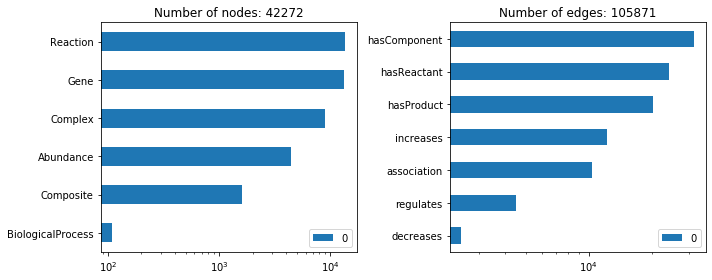

In [9]:
pathme_universe_graph_no_flatten = process_graph_from_file(GRAPH_PATH)

pathme_universe_graph_no_flatten.summarize()
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

In [10]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')


Total number of  wikipathways: gene_nodes(2555), mirna_nodes(91), metabolite_nodes(637), bp_nodes(138),  
Total number of  kegg: gene_nodes(6048), mirna_nodes(122), metabolite_nodes(1770), bp_nodes(107),  
Total number of  reactome: gene_nodes(8617), mirna_nodes(13), metabolite_nodes(2682), bp_nodes(3),  
Total: 18001 


In [11]:
bg_labels_from_pathmeuniverse_by_db = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_db_and_omic)
print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db, 'Entities in PathMeUniverse :')

Total number of  wikipathways: 3421  
Total number of  kegg: 8047  
Total number of  reactome: 11315  
Total: 18001 


In [12]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)
print_dict_dimensions(bg_labels_from_pathmeuniverse_by_omic, 'Entities in PathMeUniverse :')

Total number of  gene_nodes: 13282  
Total number of  mirna_nodes: 171  
Total number of  metabolite_nodes: 4306  
Total number of  bp_nodes: 248  
Total: 18001 


## 3. Mapping

In [13]:
from diffupy.process_input import map_labels_input
from diffupy.process_input import mapping_statistics

##### Quantitative

In [15]:
mapping_by_database_and_entity = map_labels_input(input_labels=selected_input,
                                                  background_labels=bg_labels_from_pathmeuniverse_by_db_and_omic,
                                                  show_descriptive_stat = True
                                                 ) 


Mapping descriptive statistics

wikipathways:
gene_nodes  (12, 0.21428571428571427)
metabolite_nodes  (6, 0.4)
total  (18, 0.2571428571428571)

kegg:
gene_nodes  (20, 0.35714285714285715)
mirna_nodes  (1, 1.0)
metabolite_nodes  (5, 0.3333333333333333)
total  (26, 0.3561643835616438)

reactome:
gene_nodes  (23, 0.4107142857142857)
metabolite_nodes  (5, 0.3333333333333333)
total  (28, 0.4)

total:
gene_nodes  (33, 0.4520547945205479)
metabolite_nodes  (8, 0.1095890410958904)
mirna_nodes  (1, 0.0136986301369863)
total  (42, 0.5753424657534246)




##### Descriptive data view

In [16]:
mapping_by_database_and_entity_statistics = mapping_statistics(selected_input, 
                                                               mapping_by_database_and_entity)

In [18]:
mapping_by_database_and_entity_statistics

{'wikipathways': {'gene_nodes': (12, 0.21428571428571427),
  'metabolite_nodes': (6, 0.4),
  'total': (18, 0.2571428571428571)},
 'kegg': {'gene_nodes': (20, 0.35714285714285715),
  'mirna_nodes': (1, 1.0),
  'metabolite_nodes': (5, 0.3333333333333333),
  'total': (26, 0.3561643835616438)},
 'reactome': {'gene_nodes': (23, 0.4107142857142857),
  'metabolite_nodes': (5, 0.3333333333333333),
  'total': (28, 0.4)},
 'total': {'gene_nodes': (33, 0.4520547945205479),
  'metabolite_nodes': (8, 0.1095890410958904),
  'mirna_nodes': (1, 0.0136986301369863),
  'total': (42, 0.5753424657534246)}}

In [20]:
temp = mapping_by_database_and_entity_statistics['kegg']['mirna_nodes']
mapping_by_database_and_entity_statistics['kegg'].pop('mirna_nodes')
mapping_by_database_and_entity_statistics['kegg']['mirna_nodes'] = temp

temp = mapping_by_database_and_entity_statistics['kegg']['total']
mapping_by_database_and_entity_statistics['kegg'].pop('total')
mapping_by_database_and_entity_statistics['kegg']['total'] = temp

mapping_by_database_and_entity_statistics['wikipathways']['mirna_nodes'] = (0,0)
temp = mapping_by_database_and_entity_statistics['wikipathways']['total']
mapping_by_database_and_entity_statistics['wikipathways'].pop('total')
mapping_by_database_and_entity_statistics['wikipathways']['total'] = temp

mapping_by_database_and_entity_statistics['reactome']['mirna_nodes'] = (0,0)
temp = mapping_by_database_and_entity_statistics['reactome']['total']
mapping_by_database_and_entity_statistics['reactome'].pop('total')
mapping_by_database_and_entity_statistics['reactome']['total'] = temp

mapping_by_database_and_entity_statistics

{'wikipathways': {'gene_nodes': (12, 0.21428571428571427),
  'metabolite_nodes': (6, 0.4),
  'mirna_nodes': (0, 0),
  'total': (18, 0.2571428571428571)},
 'kegg': {'gene_nodes': (20, 0.35714285714285715),
  'metabolite_nodes': (5, 0.3333333333333333),
  'mirna_nodes': (1, 1.0),
  'total': (26, 0.3561643835616438)},
 'reactome': {'gene_nodes': (23, 0.4107142857142857),
  'metabolite_nodes': (5, 0.3333333333333333),
  'mirna_nodes': (0, 0),
  'total': (28, 0.4)},
 'total': {'gene_nodes': (33, 0.4520547945205479),
  'metabolite_nodes': (8, 0.1095890410958904),
  'mirna_nodes': (1, 0.0136986301369863),
  'total': (42, 0.5753424657534246)}}

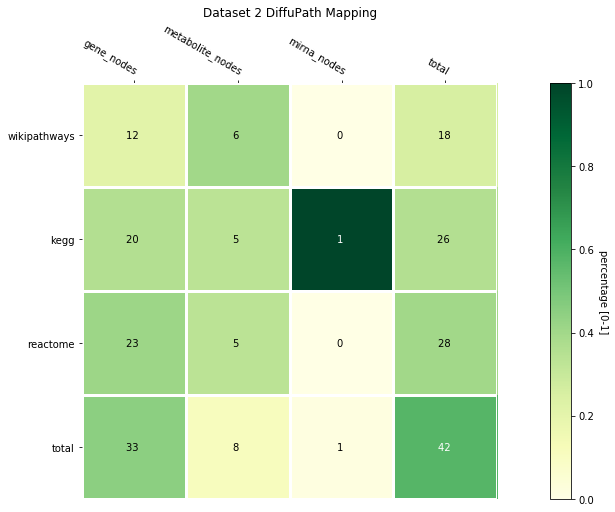

In [21]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity_statistics)

show_heatmap(count, percentage, db_labels, entity_labels, 'Dataset 2 DiffuPath Mapping')

##### Save mapping by_db_and_entity to exportable .json file

In [57]:
MAPPING_OUTPUT_PATH = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_3_mapping.json')
to_json(mapping_by_database_and_entity, MAPPING_OUTPUT_PATH)